![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Train Legal NER

In [0]:
from johnsnowlabs import * 

In [0]:
import pandas as pd

# CoNLL Data Prep

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Legal/data/conll_noO.conll
dbutils.fs.cp("file:/databricks/driver/conll_noO.conll", "dbfs:/") 

Out[3]: True

In [0]:
with open("/dbfs/conll_noO.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

( NN NN O
d NN NN O
) NN NN O
OF NN NN O
THE NN NN O
SECURITIES NN NN O
EXCHANGE NN NN O
ACT NN NN O
OF NN NN O
1934 NN NN O
For NN NN O
the NN NN O
annual NN NN O
period NN NN O
ended NN NN O
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
☐ NN NN O
TRANSITION NN NN O
REPORT NN NN O
UNDER NN NN O
SECTION NN NN O
13 NN NN O
OR NN NN O
15

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'dbfs:/conll_noO.conll')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
( d ) OF THE SECU...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
﻿ COMPANY BACKGRO...|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 0, ﻿,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
In November 2004 ...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 1, In...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 241 µs, sys: 58 µs, total: 299 µs
Wall time: 408 ms
Out[7]: 1637

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+-------------+
 token|pos| ner_label|
+----------+---+-------------+
 (| NN| O|
 d| NN| O|
 )| NN| O|
 OF| NN| O|
 THE| NN| O|
SECURITIES| NN| O|
 EXCHANGE| NN| O|
 ACT| NN| O|
 OF| NN| O|
 1934| NN| O|
 For| NN| O|
 the| NN| O|
 annual| NN| O|
 period| NN| O|
 ended| NN| O|
 March|NNP|B-FISCAL_YEAR|
 31|NNP|I-FISCAL_YEAR|
 ,|NNP|I-FISCAL_YEAR|
 2021|NNP|I-FISCAL_YEAR|
 March|NNP|B-FISCAL_YEAR|
+----------+---+-------------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------------+-----+
ground_truth |count|
+------------------+-----+
O |51912|
I-DATE |1932 |
I-FISCAL_YEAR |1812 |
B-DATE |1797 |
B-AMOUNT |1466 |
B-CURRENCY |1461 |
I-AMOUNT |1134 |
B-FISCAL_YEAR |605 |
I-EXPENSE_INCREASE|546 |
I-EXPENSE_DECREASE|390 |
B-PERCENTAGE |350 |
I-PROFIT_INCREASE |288 |
I-EXPENSE |280 |
B-EXPENSE_INCREASE|274 |
I-PROFIT |228 |
B-EXPENSE_DECREASE|191 |
B-PROFIT_INCREASE |164 |
B-EXPENSE |150 |
B-PROFIT |122 |
I-PROFIT_DECLINE |93 |
B-PROFIT_DECLINE |58 |
I-PERCENTAGE |12 |
+------------------+-----+

# Using RoBerta Embeddings

In [0]:
roberta_embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]

In [0]:
nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(1)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setOutputLogsPath('dbfs:/ner/ner_logs') # if not set, logs will be written to ~/annotator_logs
        #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
        #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
                                nerTagger
                                ])


In [0]:
roberta_embeddings.transform(training_data).write.parquet('/dbfs/ner_dl_train.parquet')

In [0]:
train_embeddings = spark.read.parquet('/dbfs/ner_dl_train.parquet')

In [0]:
%%time

ner_model = ner_pipeline.fit(train_embeddings)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

CPU times: user 107 ms, sys: 17.5 ms, total: 124 ms
Wall time: 33.7 s

In [0]:
import os

log_files = os.listdir("/dbfs/ner/ner_logs")
with open("/dbfs/ner/ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 14 - chars: 106 - training examples: 4012


Epoch 1/1 started, lr: 0.003, dataset size: 4012


Epoch 1/1 - 18.33s - loss: 1459.4712 - avg training loss: 11.402119 - batches: 128
Quality on validation dataset (20.0%), validation examples = 802
time to finish evaluation: 2.80s
Total validation loss: 189.2951	Avg validation loss: 5.5675
label tp fp fn prec rec f1
B-PERSON 0 0 12 0.0 0.0 0.0
B-LAW 103 26 56 0.79844964 0.6477987 0.7152778
I-PARTY 1812 107 552 0.9442418 0.76649743 0.84613585
B-EFFDATE 0 0 6 0.0 0.0 0.0
B-LOC 16 9 37 0.64 0.3018868 0.41025642
B-DATE 292 48 86 0.85882354 0.77248675 0.81337047
B-DOC 289 154 97 0.6523702 0.7487047 0.6972256
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 511 207 65 0.7116992 0.8871528 0.7897991
B-ORDINAL 12 0 10 1.0 0.54545456 0.7058824
B-ROLE 44 11 24 0.8 0.64705884 0.7154471
B-PERCENT 2 0 24 1.0 0.07692308 0.14285713
B-PARTY 734 174 481 0.80837005 0.60411525 0.6914743
tp: 3815 fp: 736 fn: 1462 labels: 13
Macro-average prec: 0.6318426, rec: 0.46139064, f1: 0.5333286
Micro-average prec: 0.8382773, rec: 0.7229487, f1: 0.7763533
Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 14 - chars: 105 - training examples: 4005


Epoch 1/1 started, lr: 0.003, dataset size: 4005


Epoch 1/1 - 18.66s - loss: 1579.8114 - avg training loss: 12.342277 - batches: 128
Quality on validation dataset (20.0%), validation examples = 801
time to finish evaluation: 3.09s
Total validation loss: 171.1252	Avg validation loss: 5.0331
label tp fp fn prec rec f1
B-PERSON 0 0 5 0.0 0.0 0.0
B-LAW 93 29 80 0.76229507 0.53757226 0.6305085
I-PARTY 2114 87 238 0.9604725 0.89880955 0.92861855
B-EFFDATE 0 0 5 0.0 0.0 0.0
B-LOC 9 2 59 0.8181818 0.13235295 0.22784811
B-DATE 300 67 58 0.8174387 0.83798885 0.82758623
B-DOC 245 40 151 0.8596491 0.61868685 0.7195301
I-EFFDATE 0 0 18 0.0 0.0 0.0
I-DOC 522 110 131 0.8259494 0.79938745 0.81245136
B-ORDINAL 3 0 29 1.0 0.09375 0.17142858
B-ROLE 12 0 57 1.0 0.17391305 0.2962963
B-PERCENT 3 0 17 1.0 0.15 0.2608696
B-PARTY 747 194 395 0.79383636 0.65411556 0.71723473
tp: 4048 fp: 529 fn: 1243 labels: 13
Macro-average prec: 0.6798325, rec: 0.37665975, f1: 0.48474663
Micro-average prec: 0.8844221, rec: 0.76507276, f1: 0.8204297

![2.jpg](/files/FINLEG/2.jpg)

### Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'dbfs:/conll_noO.conll')

(train_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 3458
Test Dataset Count: 1564

In [0]:
!mkdir /dbfs/ner/ner_logs_best_leg

In [0]:
roberta_embeddings.transform(train_data).write.parquet('/dbfs/ner_dl_trainining.parquet')
roberta_embeddings.transform(test_data).write.parquet('/dbfs/ner_dl_test.parquet')

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2232641861142504> in <module> 
 ----> 1 roberta_embeddings . transform ( train_data ) . write . parquet ( '/dbfs/ner_dl_trainining.parquet' ) 
 2 roberta_embeddings . transform ( test_data ) . write . parquet ( '/dbfs/ner_dl_test.parquet' ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 1275 self . partitionBy ( partitionBy ) 
 1276 self . _set_opts ( compression = compression ) 
 -> 1277 self . _jwrite . parquet ( path ) 
 1278 
 1279 def text ( self , path , compression = None , lineSep = None ) : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : path dbfs:/dbfs/ner_dl_trainining.parquet already exists.

In [0]:
train_embeddings = spark.read.parquet('/dbfs/ner_dl_trainining.parquet')

In [0]:
%%time

nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setUseBestModel(True)\
              .setTestDataset('/dbfs/ner_dl_test.parquet')\
              .setOutputLogsPath('dbfs:/ner/ner_logs_best_leg') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
                                nerTagger
                                ])


ner_model = ner_pipeline.fit(train_embeddings)

CPU times: user 213 ms, sys: 50.5 ms, total: 263 ms
Wall time: 1min 11s

In [0]:
import os
log_files = os.listdir("/dbfs/ner/ner_logs_best_leg")
log_files

Out[39]: ['LegalNerApproach_2208dbd7a51b.log']

In [0]:
with open("/dbfs/ner/ner_logs_best_leg/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 14 - chars: 117 - training examples: 2787


Epoch 1/3 started, lr: 0.003, dataset size: 2787


Epoch 1/3 - 12.52s - loss: 1366.6758 - avg training loss: 15.1852865 - batches: 90
Quality on validation dataset (20.0%), validation examples = 557
time to finish evaluation: 2.44s
Total validation loss: 144.8510	Avg validation loss: 6.2979
label tp fp fn prec rec f1
B-PERSON 0 0 20 0.0 0.0 0.0
B-LAW 40 5 76 0.8888889 0.3448276 0.49689445
I-PARTY 1344 159 206 0.8942116 0.8670968 0.8804454
B-EFFDATE 0 0 4 0.0 0.0 0.0
B-LOC 0 0 25 0.0 0.0 0.0
B-DATE 215 38 64 0.8498024 0.7706093 0.8082707
B-DOC 89 16 183 0.84761906 0.3272059 0.47214857
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 180 20 238 0.9 0.430622 0.5825243
B-ORDINAL 0 0 12 0.0 0.0 0.0
B-ROLE 4 0 37 1.0 0.09756097 0.17777777
B-PERCENT 2 0 19 1.0 0.0952381 0.17391305
B-PARTY 470 150 303 0.7580645 0.6080207 0.67480254
tp: 2344 fp: 388 fn: 1199 labels: 13
Macro-average prec: 0.549122, rec: 0.2723986, f1: 0.3641541
Micro-average prec: 0.8579795, rec: 0.6615862, f1: 0.74709165
Quality on test dataset: 
time to finish evaluation: 5.86s
Total test loss: 267.0366	Avg test loss: 13.3518
label tp fp fn prec rec f1
I-AMOUNT 0 0 365 0.0 0.0 0.0
I-PARTY 0 271 0 0.0 0.0 0.0
B-AMOUNT 0 0 463 0.0 0.0 0.0
B-DATE 0 0 633 0.0 0.0 0.0
I-DATE 0 0 681 0.0 0.0 0.0
I-EXPENSE 0 0 108 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 57 0.0 0.0 0.0
B-EXPENSE 0 0 57 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 23 0.0 0.0 0.0
I-PROFIT 0 0 72 0.0 0.0 0.0
B-CURRENCY 0 0 462 0.0 0.0 0.0
I-PROFIT_INCREASE 0 0 110 0.0 0.0 0.0
B-PROFIT 0 0 38 0.0 0.0 0.0
B-PERCENTAGE 0 0 111 0.0 0.0 0.0
I-FISCAL_YEAR 0 0 577 0.0 0.0 0.0
B-PROFIT_DECLINE 0 0 13 0.0 0.0 0.0
B-PARTY 0 205 0 0.0 0.0 0.0
B-EXPENSE_INCREASE 0 0 91 0.0 0.0 0.0
B-EXPENSE_DECREASE 0 0 42 0.0 0.0 0.0
B-FISCAL_YEAR 0 0 192 0.0 0.0 0.0
I-EXPENSE_DECREASE 0 0 86 0.0 0.0 0.0
I-EXPENSE_INCREASE 0 0 196 0.0 0.0 0.0
tp: 0 fp: 476 fn: 4377 labels: 22
Macro-average prec: 0.0, rec: 0.0, f1: NaN
Micro-average prec: 0.0, rec: 0.0, f1: 0.0


Epoch 2/3 started, lr: 0.0029850747, dataset size: 2787


Epoch 2/3 - 11.67s - loss: 549.13513 - avg training loss: 6.1015015 - batches: 90
Quality on validation dataset (20.0%), validation examples = 557
time to finish evaluation: 1.40s
Total validation loss: 107.8204	Avg validation loss: 4.6878
label tp fp fn prec rec f1
B-PERSON 0 0 20 0.0 0.0 0.0
B-LAW 86 16 30 0.84313726 0.7413793 0.78899086
I-PARTY 1498 284 52 0.8406285 0.9664516 0.89915967
B-EFFDATE 0 0 4 0.0 0.0 0.0
B-LOC 15 54 10 0.2173913 0.6 0.31914893
B-DATE 238 34 41 0.875 0.8530466 0.86388385
B-DOC 182 34 90 0.8425926 0.6691176 0.74590164
I-EFFDATE 0 0 12 0.0 0.0 0.0
I-DOC 341 61 77 0.84825873 0.81578946 0.8317073
B-ORDINAL 3 0 9 1.0 0.25 0.4
B-ROLE 23 3 18 0.88461536 0.5609756 0.6865672
B-PERCENT 4 0 17 1.0 0.1904762 0.32000002
B-PARTY 534 143 239 0.788774 0.69081503 0.7365518
tp: 2924 fp: 629 fn: 619 labels: 13
Macro-average prec: 0.62618446, rec: 0.48754242, f1: 0.54823405
Micro-average prec: 0.8229665, rec: 0.8252893, f1: 0.82412624
Quality on test dataset: 
time to finish evaluation: 6.29s
Total test loss: 607.4203	Avg test loss: 30.3710
label tp fp fn prec rec f1
I-AMOUNT 0 0 365 0.0 0.0 0.0
B-LAW 0 42 0 0.0 0.0 0.0
I-PARTY 0 3859 0 0.0 0.0 0.0
B-AMOUNT 0 0 463 0.0 0.0 0.0
B-LOC 0 33 0 0.0 0.0 0.0
B-DATE 0 5 633 0.0 0.0 0.0
B-DOC 0 3 0 0.0 0.0 0.0
I-DATE 0 0 681 0.0 0.0 0.0
I-EXPENSE 0 0 108 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 57 0.0 0.0 0.0
B-EXPENSE 0 0 57 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 23 0.0 0.0 0.0
I-PROFIT 0 0 72 0.0 0.0 0.0
B-CURRENCY 0 0 462 0.0 0.0 0.0
I-PROFIT_INCREASE 0 0 110 0.0 0.0 0.0
B-PROFIT 0 0 38 0.0 0.0 0.0
B-PERCENTAGE 0 0 111 0.0 0.0 0.0
I-FISCAL_YEAR 0 0 577 0.0 0.0 0.0
B-PROFIT_DECLINE 0 0 13 0.0 0.0 0.0
B-PARTY 0 1444 0 0.0 0.0 0.0
B-EXPENSE_INCREASE 0 0 91 0.0 0.0 0.0
B-EXPENSE_DECREASE 0 0 42 0.0 0.0 0.0
B-FISCAL_YEAR 0 0 192 0.0 0.0 0

In [0]:
test_data = roberta_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [0]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

precision recall f1-score support

 B-DATE 0.8899 0.6312 0.7386 602
 B-DOC 0.9037 0.4311 0.5837 631
 B-EFFDATE 0.0000 0.0000 0.0000 6
 B-LAW 0.8359 0.5169 0.6388 207
 B-LOC 0.0000 0.0000 0.0000 70
 B-ORDINAL 0.0000 0.0000 0.0000 54
 B-PARTY 0.8311 0.5587 0.6682 1815
 B-PERCENT 0.0000 0.0000 0.0000 32
 B-PERSON 0.0000 0.0000 0.0000 30
 B-ROLE 0.8421 0.1649 0.2759 97
 I-DOC 0.8723 0.5869 0.7017 978
 I-EFFDATE 0.0000 0.0000 0.0000 11
 I-PARTY 0.9133 0.8436 0.8771 3797
 O 0.9012 0.9853 0.9414 22181

 accuracy 0.8987 30511
 macro avg 0.4993 0.3370 0.3875 30511
weighted avg 0.8908 0.8987 0.8876 30511

In [0]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).show(truncate=False)



+-------------------+------------+----------+
token |ground_truth|prediction|
+-------------------+------------+----------+
" |O |O |
Berkshire |B-PARTY |B-PARTY |
Bank |I-PARTY |I-PARTY |
(Berkshire)("Party"|I-PARTY |I-PARTY |
or |I-PARTY |O |
"Parties") |I-PARTY |O |
Revenue |O |O |
Account |O |O |
" |O |O |
means |O |O |
the |O |O |
bank |O |O |
account |O |O |
designed |O |O |
by |O |O |
iBio |B-PARTY |B-PARTY |
Inc. |I-PARTY |I-PARTY |
as |O |O |
its |O |O |
revenue |O |O |
+-------------------+------------+----------+
only showing top 20 rows

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

dbutils.fs.cp("file:/databricks/driver/conll_eval.py", "dbfs:/") 

Out[27]: True

In [0]:
spark.sparkContext.addPyFile("dbfs:/conll_eval.py")
import conll_eval

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 30511 tokens with 3544 phrases; found: 2382 phrases; correct: 1625.
accuracy: 66.82%; (non-O)
accuracy: 89.87%; precision: 68.22%; recall: 45.85%; FB1: 54.84
 DATE: precision: 88.99%; recall: 63.12%; FB1: 73.86 427
 DOC: precision: 56.35%; recall: 37.24%; FB1: 44.85 417
 EFFDATE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 LAW: precision: 83.59%; recall: 51.69%; FB1: 63.88 128
 LOC: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 ORDINAL: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 PARTY: precision: 63.77%; recall: 48.87%; FB1: 55.33 1391
 PERCENT: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 PERSON: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 ROLE: precision: 84.21%; recall: 16.49%; FB1: 27.59 19

In [0]:
# micro, macro, avg
metrics[0]

Out[30]: (68.21998320738875, 45.85214446952596, 54.843064461694226)

In [0]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[31]:

,entity,precision,recall,f1,support
0,DATE,88.992974,63.122924,73.858115,427
1,DOC,56.354916,37.242472,44.847328,417
2,EFFDATE,0.000000,0.000000,0.000000,0
3,LAW,83.593750,51.690821,63.880597,128
4,LOC,0.000000,0.000000,0.000000,0
5,ORDINAL,0.000000,0.000000,0.000000,0
6,PARTY,63.767074,48.870523,55.333749,1391
7,PERCENT,0.000000,0.000000,0.000000,0
8,PERSON,0.000000,0.000000,0.000000,0
9,ROLE,84.210526,16.494845,27.586207,19


### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

dbutils.fs.cp("file:/databricks/driver/ner_log_parser.py", "dbfs:/") 

Out[32]: True

In [0]:
spark.sparkContext.addPyFile("dbfs:/ner_log_parser.py")

import ner_log_parser

In [0]:
%matplotlib inline

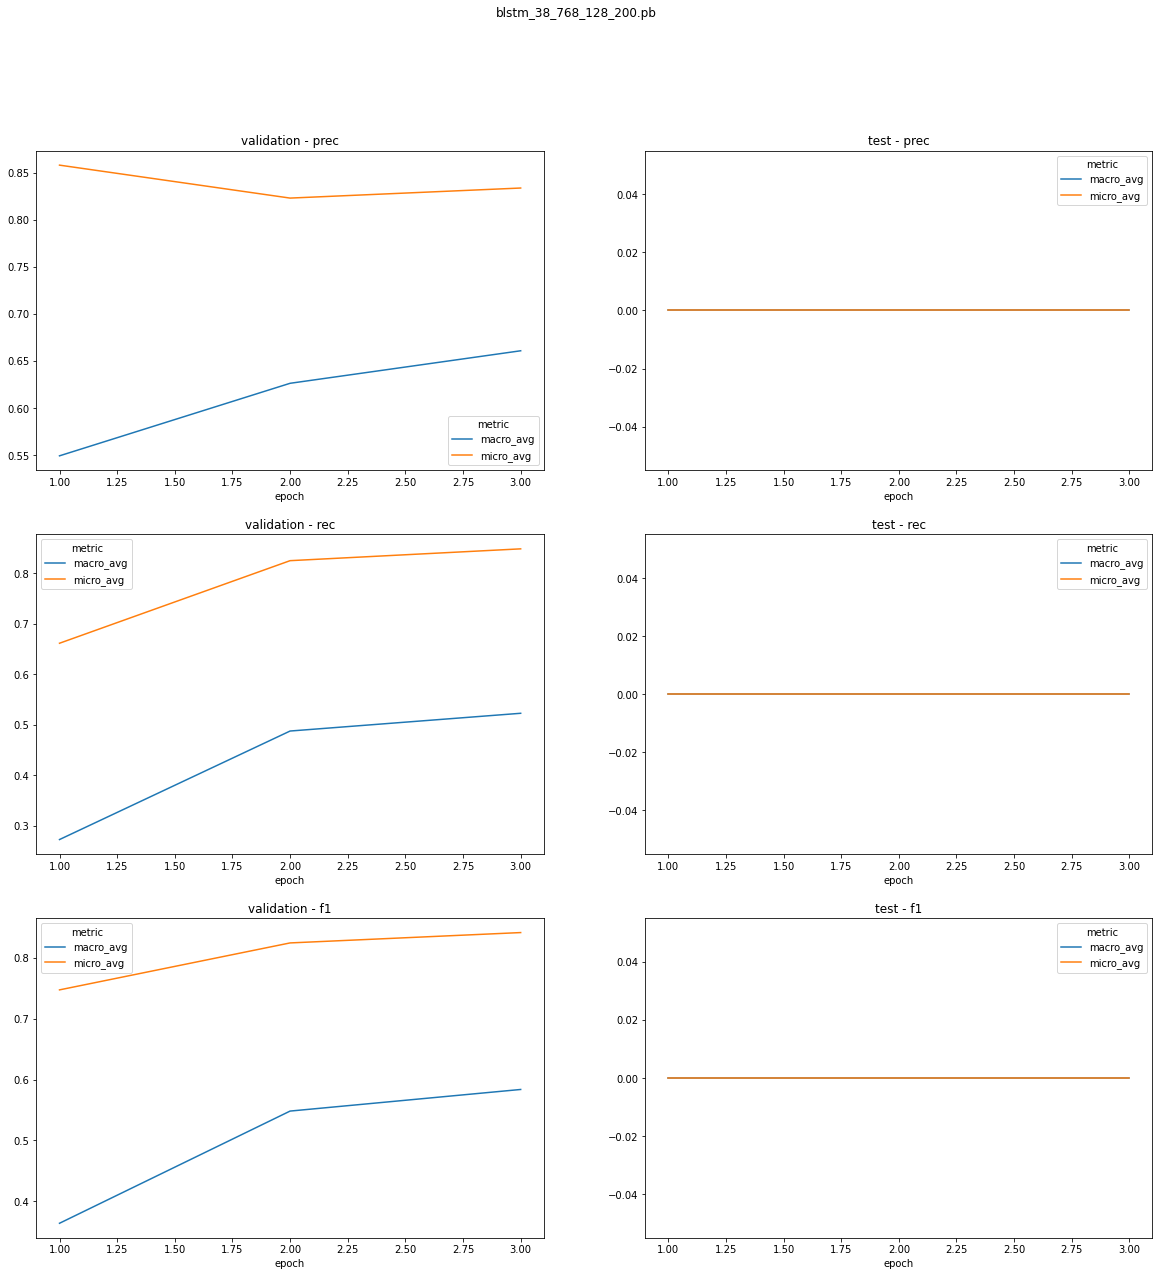

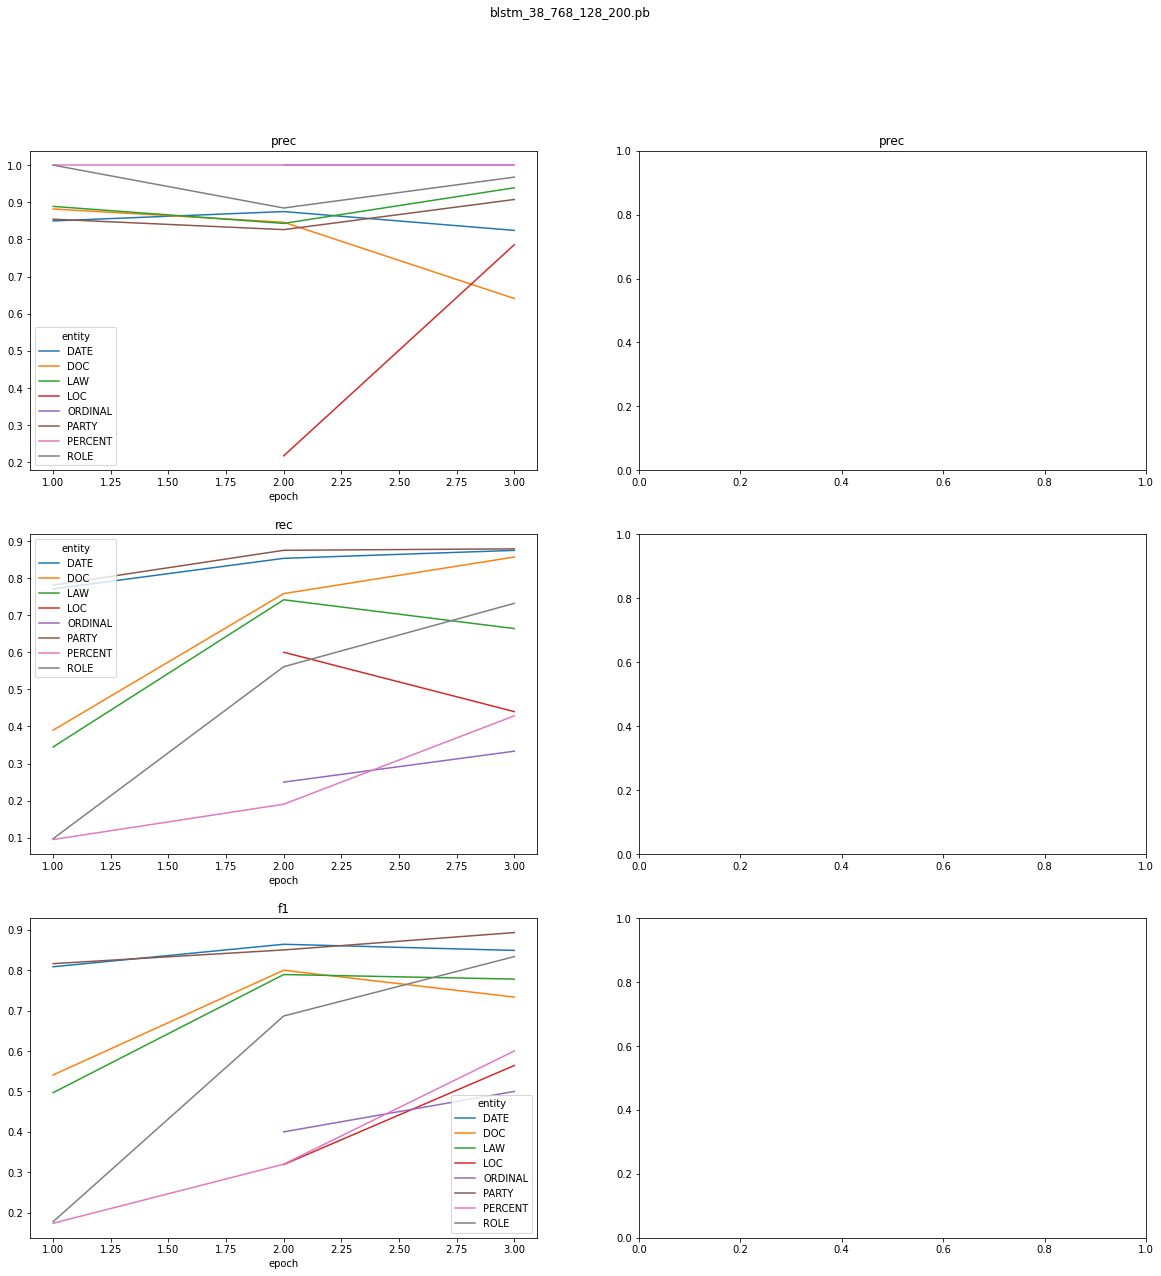

In [0]:
ner_log_parser.get_charts('/dbfs/ner/ner_logs_best_leg/'+log_files[0])

**Plotting Loss**

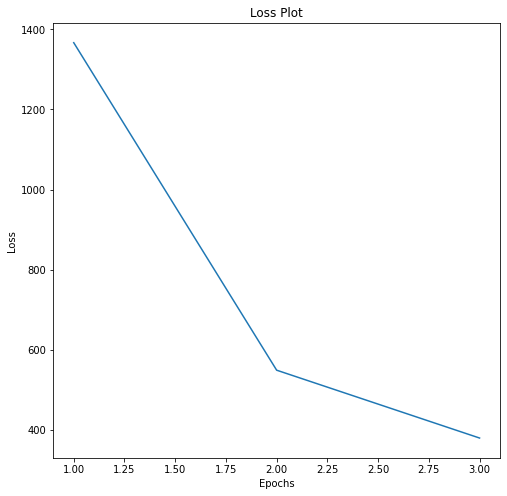

In [0]:
ner_log_parser.loss_plot('/dbfs/ner/ner_logs_best_leg/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[45]: [FinanceNerModel_8b59a69bdd83]

In [0]:
ner_model.stages[-1].write().overwrite().save('/dbfs/NER_bert_e5_b32')

In [0]:
!ls -lt

total 832
-rw-r--r-- 1 root root 3826 Oct 17 04:18 ner_log_parser.py
-rw-r--r-- 1 root root 7431 Oct 17 04:17 conll_eval.py.1
drwxr-xr-x 2 root root 4096 Oct 17 04:15 ganglia
-rw-r--r-- 1 root root 7431 Oct 17 04:13 conll_eval.py
drwxr-xr-x 2 root root 4096 Oct 17 04:06 logs
drwxr-xr-x 3 root root 4096 Oct 17 04:05 eventlogs
-r-xr-xr-x 1 root root 813069 Oct 17 03:14 preload_class.lst
drwxr-xr-x 2 root root 4096 Oct 17 03:14 conf

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

roberta_embeddings = RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = legal.NerModel.load("/dbfs/NER_bert_e5_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
                                            document,
                                            sentence,
                                            token,
                                            roberta_embeddings,
                                            loaded_ner_model,
                                            converter
                                            ])

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [0]:
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+---------------------------------------+
text |
+---------------------------------------+
ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6|
+---------------------------------------+

In [0]:
%%time
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+-----------------------------+------+
chunk |entity|
+-----------------------------+------+
II ENGAGEMENT OF ZEBRA BRAZIL|DOC |
+-----------------------------+------+

CPU times: user 24.9 ms, sys: 16.9 ms, total: 41.8 ms
Wall time: 3.37 s

In [0]:
light_model = LightPipeline(prediction_model)

In [0]:
%%time
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

CPU times: user 20.7 ms, sys: 4.15 ms, total: 24.8 ms
Wall time: 2.11 s
Out[53]: [('ARTICLE', 'O'),
 ('II', 'B-DOC'),
 ('ENGAGEMENT', 'I-DOC'),
 ('OF', 'I-DOC'),
 ('ZEBRA', 'I-DOC'),
 ('BRAZIL', 'I-DOC'),
 ('6', 'O')]

In [0]:
%%time
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

CPU times: user 42.7 ms, sys: 24.1 ms, total: 66.8 ms
Wall time: 627 ms
Out[54]:

,sent_id,token,start,end,ner
0,0,ARTICLE,0,6,O
1,0,II,8,9,B-DOC
2,0,ENGAGEMENT,11,20,I-DOC
3,0,OF,22,23,I-DOC
4,0,ZEBRA,25,29,I-DOC
5,0,BRAZIL,31,36,I-DOC
6,0,6,38,38,O


### **Highlight Entities**

In [0]:
from sparknlp_display import NerVisualizer


result = result[0]
visualiser = NerVisualizer()
viz = visualiser.display(result, label_col='ner_span', document_col='document',return_html=True)
displayHTML(viz)

ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL DOC 6

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
# %%capture

# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

# %tensorflow_version 2.7.0

# import create_graph

# ntags = 19 # number of labels
# embeddings_dim = 100
# nchars =100

# create_graph.create_graph(ntags, embeddings_dim, nchars)

# # then move the graph to grap folder stated in NerDLApproach